From the file phase1_import_tweets.py I imported 34339 tweets that contains any of these words Russia, Ukraine, or #UkraineRussiaWar.

#### Import necessary libraries 

In [1]:
import pandas as pd
import numpy as np
import seaborn  as sns
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words
nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


 # 1. Import Raw Data

#### Read raw Data to a Dataframe
After importing the tweets using the Twitter API in the import_tweets_hashtag.py file, we will read it using a dataframe, and check the shape and the missing data on the raw data

In [2]:
raw_df = pd.read_csv('./data/raw_data.csv')
#raw_df.sample(10)
raw_df.shape

(26000, 17)

#### Data Dictionary 

| Syntax                | Description |
| -----------           | ----------- |
|- tweetID :            | The unique identifier for Tweet. The dataset contain 34339 uniq tweets | 
|- tweetText :          | The actual text of the tweet |
|- tweetRetweetCt :     | Number of times this Tweet has been retweeted|
|- tweetFavoriteCt:     | Indicates approximately how many times this Tweet has been liked by Twitter users |
|- tweetCreated:        | UTC time when this Tweet was created  |
|- userID:              | The user ID who posted this Tweet |
|- userName:            | The user Name who posted this Tweet |
|- userLocation:        | The location of the user  |
|- Tweetcountry:        | The location of the user  |

<AxesSubplot:>

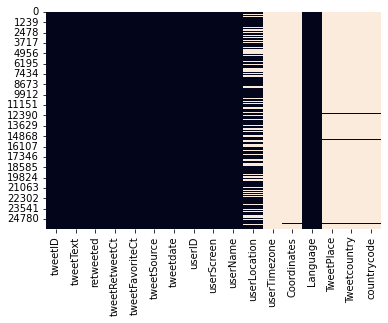

In [3]:
sns.heatmap(raw_df.isnull(), cbar=False)

In [4]:
print('Missing Tweet Place: ',raw_df['TweetPlace'].isnull().sum())

Missing Tweet Place:  25678


#### Find and delete the duplicate tweets

In [ ]:
#print(raw_df.tweetText.value_counts())
raw_df['duplicattweet'] = raw_df.duplicated(subset=['tweetText'], keep='first')
print(raw_df.duplicattweet.value_counts())
raw_df.drop(raw_df[raw_df.duplicattweet == True].index, inplace=True)
print(raw_df.duplicattweet.value_counts())

#### Chage the tweetdate column to datetime and extract only date to another column 

In [5]:
raw_df['tweetdate'] = pd.to_datetime(raw_df['tweetdate'])
raw_df['date'] = raw_df['tweetdate'].dt.date
raw_df.date.value_counts()

2022-02-28    26000
Name: date, dtype: int64

# 2. Cleaning Process

## Text Pre-Processing

In [6]:
#tweet_df = pd.read_csv('./data/cleaned_data.csv')
tweet_df = raw_df[['tweetText','tweetdate','date']]

In [7]:
tweet_df['tweetText'].head()

0    @RealPepeEscobar Flush those fancy degrees dow...
1    Hey @GrantRandom, while listening to @SXMOctan...
2    Stephen King stands with #Ukraine!\n@StephenKi...
3    @kilogolfsierra @form_whisperer @EdwardGLuce U...
4    @indiana_imo It's because Russia is a nuclear ...
Name: tweetText, dtype: object

In [8]:
# source: https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text= re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [9]:
# to add cleanText column to the the dataframe, this process take almost 2 min
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
    
tweet_df['cleanText'] = tweet_df['tweetText'].apply(lambda x: finalpreprocess(x))
tweet_df.head()

/tmp/ipykernel_6403/1996692118.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df['cleanText'] = tweet_df['tweetText'].apply(lambda x: finalpreprocess(x))


,tweetText,tweetdate,date,cleanText
0,@RealPepeEscobar Flush those fancy degrees dow...,2022-02-28 22:32:28+00:00,2022-02-28,realpepeescobar flush fancy degree toilet saw ...
1,"Hey @GrantRandom, while listening to @SXMOctan...",2022-02-28 22:32:28+00:00,2022-02-28,hey grantrandom listen sxmoctane late last nig...
2,Stephen King stands with #Ukraine!\n@StephenKi...,2022-02-28 22:32:28+00:00,2022-02-28,stephen king stand ukraine stephenking stephen...
3,@kilogolfsierra @form_whisperer @EdwardGLuce U...,2022-02-28 22:32:28+00:00,2022-02-28,kilogolfsierra form whisperer edwardgluce ukra...
4,@indiana_imo It's because Russia is a nuclear ...,2022-02-28 22:32:28+00:00,2022-02-28,indiana imo russia nuclear superpower aggressi...


In [10]:
# add aditional words to stopword list
stop_words = set(stopwords.words('english'))
additional_stopwords = {'I','-','&map','amp','would','this','we','the','you','co','http','https','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'}
stop_words.update(additional_stopwords)
#type(stop_words)
#print(stop_words)

# STOPWORD REMOVAL
def removestopword(string):
    a= [i for i in string.split() if i not in stop_words]
    return ' '.join(a)

In [11]:
tweet_df['cleanText'] = tweet_df['cleanText'].apply(lambda x: removestopword(x))

/tmp/ipykernel_6403/2460791469.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df['cleanText'] = tweet_df['cleanText'].apply(lambda x: removestopword(x))


In [12]:
from collections import Counter
print(Counter(" ".join(tweet_df['cleanText']).split()).most_common(20))

[('ukraine', 13218), ('russia', 8900), ('russian', 2793), ('putin', 2691), ('war', 2223), ('people', 1630), ('nato', 1367), ('say', 1348), ('go', 1296), ('world', 1058), ('get', 1039), ('invasion', 957), ('ukrainian', 954), ('think', 916), ('country', 906), ('support', 893), ('like', 881), ('want', 850), ('help', 838), ('know', 784)]


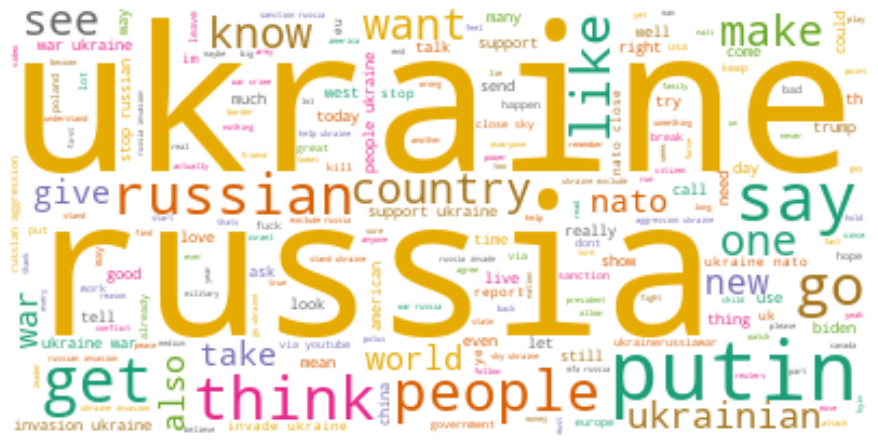

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

tweet_word = " ".join(title for title in tweet_df.cleanText)
plt.rcParams['figure.figsize'] = [16, 6]

cloud = wc.generate(tweet_word)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.imshow(cloud, interpolation='bilinear')
plt.show()

### Extracting countries, emotion, Noun/Adjective from tweets

#### 1- countries

In [14]:
import re
import string

def countWords(data_frame, selected_words):
    words_dict = {}
    
    for sentence in data_frame:
        remove = string.punctuation
        remove = remove.replace("'", "") # don't remove hyphens
        pattern = r"[{}]".format(remove) # create the pattern

        test = re.sub(pattern, "", str(sentence)) #compile

        splited_words = str(test).split(' ')

        for word in splited_words:
            word = word.strip()
            word = word.lower()
            if word in selected_words:
                if word not in words_dict:
                    words_dict[word] = 1
                else:
                    words_dict[word] += 1
    return words_dict

In [95]:
import pycountry
countries_list = []
for country in pycountry.countries:
     countries_list.append(country.name.lower())
countries_list.append('russia')
countries_list.append('united state')
countries_list.append('england')
countries_list.append('saudi')

In [99]:
import operator
extracted_countries = countWords(tweet_df['cleanText'],countries_list)
print(dict(sorted(extracted_countries.items(), key=operator.itemgetter(1),reverse=True)))

{'ukraine': 13218, 'russia': 8900, 'china': 381, 'poland': 262, 'canada': 253, 'israel': 183, 'belarus': 181, 'germany': 115, 'turkey': 98, 'iraq': 95, 'india': 81, 'afghanistan': 72, 'finland': 70, 'switzerland': 57, 'ireland': 54, 'nigeria': 47, 'france': 46, 'hungary': 40, 'sweden': 34, 'georgia': 32, 'australia': 29, 'libya': 28, 'jordan': 26, 'cuba': 24, 'serbia': 24, 'yemen': 24, 'japan': 24, 'bulgaria': 23, 'romania': 23, 'saudi': 22, 'pakistan': 20, 'latvia': 19, 'brazil': 18, 'monaco': 17, 'mexico': 17, 'qatar': 15, 'somalia': 14, 'norway': 12, 'estonia': 11, 'slovakia': 11, 'lithuania': 11, 'greece': 9, 'armenia': 9, 'egypt': 8, 'ethiopia': 8, 'azerbaijan': 8, 'myanmar': 7, 'italy': 6, 'england': 6, 'lebanon': 6, 'peru': 6, 'croatia': 6, 'jersey': 6, 'slovenia': 5, 'cyprus': 5, 'mali': 5, 'kenya': 4, 'argentina': 4, 'kuwait': 4, 'kazakhstan': 4, 'singapore': 4, 'netherlands': 4, 'spain': 4, 'congo': 4, 'portugal': 3, 'austria': 3, 'belize': 3, 'chile': 2, 'senegal': 2, 'zimba

In [17]:
def getkeyList(dict):
    return list(dict.keys())

def getvalueList(dict):
    return list(dict.values())

import random
def getcolorlist(count):
    color_list = []
    for i in range(count):
        color_list.append("#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)]))
    return color_list

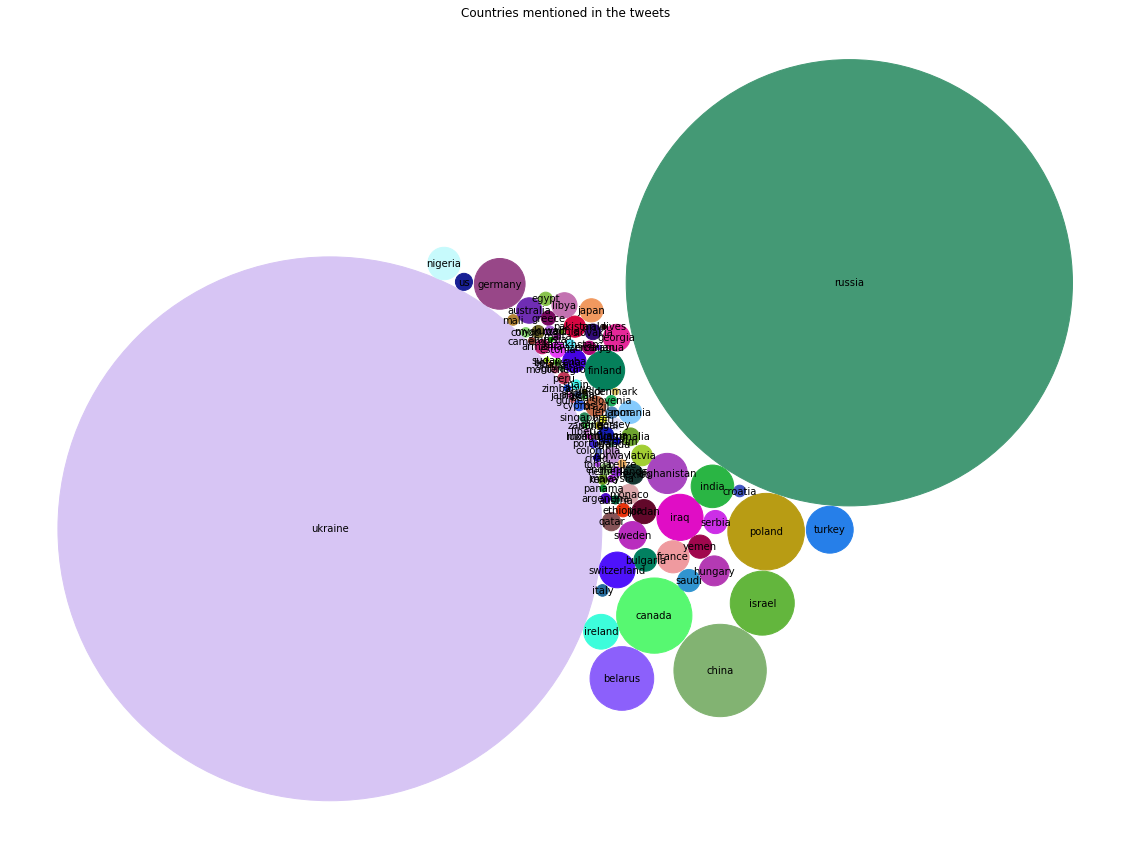

In [18]:
import numpy as np
import matplotlib.pyplot as plt

mentioned_countries = {
    'countries': getkeyList(extracted_countries),
    'freq': (getvalueList(extracted_countries)),
    'color': getcolorlist(len(extracted_countries.keys()))
}

class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        idx_min = np.argmin(distance)
        return idx_min if type(idx_min) == np.ndarray else [idx_min]

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center')


bubble_chart = BubbleChart(area=mentioned_countries['freq'],
                           bubble_spacing=0.1)

bubble_chart.collapse()

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"), figsize=(20,15))
bubble_chart.plot(
    ax, mentioned_countries['countries'], mentioned_countries['color'])
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('Countries mentioned in the tweets')

plt.show()

In [19]:
def target_ukraine (row):
   if 'ukraine' in row['cleanText'] or 'ukraian' in row['cleanText']:
      return True
   else:
      return False

def target_russia (row):
   if 'russia' in row['cleanText']:
      return True
   else:
      return False

In [20]:
tweet_df['ukraine'] = tweet_df.apply (lambda row: target_ukraine(row), axis=1)
tweet_df['russia'] = tweet_df.apply (lambda row: target_russia(row), axis=1)

/tmp/ipykernel_6403/2076405124.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df['ukraine'] = tweet_df.apply (lambda row: target_ukraine(row), axis=1)
/tmp/ipykernel_6403/2076405124.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df['russia'] = tweet_df.apply (lambda row: target_russia(row), axis=1)


In [21]:
tweet_df.head()

,tweetText,tweetdate,date,cleanText,ukraine,russia
0,@RealPepeEscobar Flush those fancy degrees dow...,2022-02-28 22:32:28+00:00,2022-02-28,realpepeescobar flush fancy degree toilet saw ...,False,False
1,"Hey @GrantRandom, while listening to @SXMOctan...",2022-02-28 22:32:28+00:00,2022-02-28,hey grantrandom listen sxmoctane late last nig...,False,False
2,Stephen King stands with #Ukraine!\n@StephenKi...,2022-02-28 22:32:28+00:00,2022-02-28,stephen king stand ukraine stephenking stephen...,True,True
3,@kilogolfsierra @form_whisperer @EdwardGLuce U...,2022-02-28 22:32:28+00:00,2022-02-28,kilogolfsierra form whisperer edwardgluce ukra...,True,True
4,@indiana_imo It's because Russia is a nuclear ...,2022-02-28 22:32:28+00:00,2022-02-28,indiana imo russia nuclear superpower aggressi...,False,True


In [22]:
ukraine_df = tweet_df.loc[(tweet_df['ukraine'] == True), ['tweetText','cleanText']]
russia_df = tweet_df.loc[(tweet_df['russia'] == True), ['tweetText','cleanText']]
print('ukraine_df: ',ukraine_df.shape , ' ,russia_df: ',russia_df.shape)

ukraine_df:  (12942, 2)  ,russia_df:  (11391, 2)


#### 2- Emotions

In [23]:
#https://www.geeksforgeeks.org/emotion-classification-using-nrc-lexicon-in-python/
#emotion
from nrclex import NRCLex

ukraine_text_list = ukraine_df['cleanText'].to_list()
ukraine_emotion = []
for i in range(len(ukraine_text_list)):
    ukraine_emotion.append(NRCLex(ukraine_text_list[i]))

russia_text_list = russia_df['cleanText'].to_list()
russia_emotion = []
for i in range(len(russia_text_list)):
    russia_emotion.append(NRCLex(russia_text_list[i]))

In [24]:
ukraine_emotion_dic = {}    
for i in range(len(ukraine_emotion)):
    ukraine_emotion_dic.update((ukraine_emotion[i]).raw_emotion_scores)

russia_emotion_dic = {}    
for i in range(len(russia_emotion)):
    russia_emotion_dic.update((russia_emotion[i]).raw_emotion_scores)
#print(russia_emotion_dic)

In [25]:
emotion_dic = {'ukraine':{} , 'russia':{}}
emotion_dic['ukraine'].update(ukraine_emotion_dic)
emotion_dic['russia'].update(russia_emotion_dic)

In [105]:
print('ukraine_emotion: ', emotion_dic['ukraine'])
print('russia_emotion: ',emotion_dic['russia'])

ukraine_emotion:  {'positive': 1, 'fear': 3, 'negative': 4, 'sadness': 1, 'anger': 1, 'anticipation': 1, 'disgust': 1, 'surprise': 1, 'joy': 2, 'trust': 1}
russia_emotion:  {'positive': 1, 'fear': 3, 'negative': 4, 'sadness': 1, 'anger': 1, 'anticipation': 1, 'surprise': 1, 'joy': 1, 'trust': 1, 'disgust': 1}


<AxesSubplot:xlabel='emotion'>

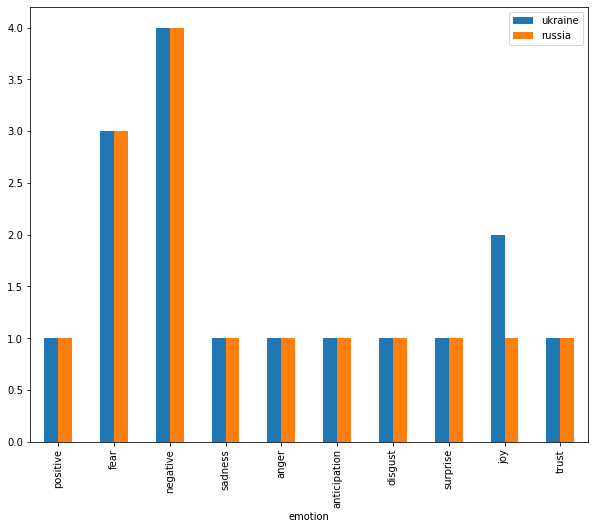

In [107]:
emotion_list = []
ukraine_emotion_value = []
russia_emotion_value = []

for emotion in ukraine_emotion_dic:
    if emotion not in emotion_list:
        emotion_list.append(emotion)
        ukraine_emotion_value.append(emotion_dic['ukraine'].get(emotion))
        russia_emotion_value.append(emotion_dic['russia'].get(emotion))

#print(emotion_list,ukraine_emotion_value,russia_emotion_value)
emotion_df = pd.DataFrame({'emotion':emotion_list,'ukraine':ukraine_emotion_value, 'russia':russia_emotion_value})
#emotion_df
# plotting graph
emotion_df.plot(x="emotion", y=["ukraine", "russia"], kind="bar",figsize=(10,8))

In [110]:
all_text_list = tweet_df['cleanText'].to_list()
all_emotion = []
for i in range(len(all_text_list)):
    all_emotion.append(NRCLex(all_text_list[i]))

all_emotion_dic = {}    
for i in range(len(all_emotion)):
    all_emotion_dic.update((all_emotion[i]).raw_emotion_scores)

all_emotion_dic


{'positive': 1,
 'anticipation': 1,
 'joy': 1,
 'disgust': 1,
 'negative': 4,
 'sadness': 1,
 'fear': 3,
 'anger': 1,
 'surprise': 1,
 'trust': 1}

<AxesSubplot:xlabel='emotion'>

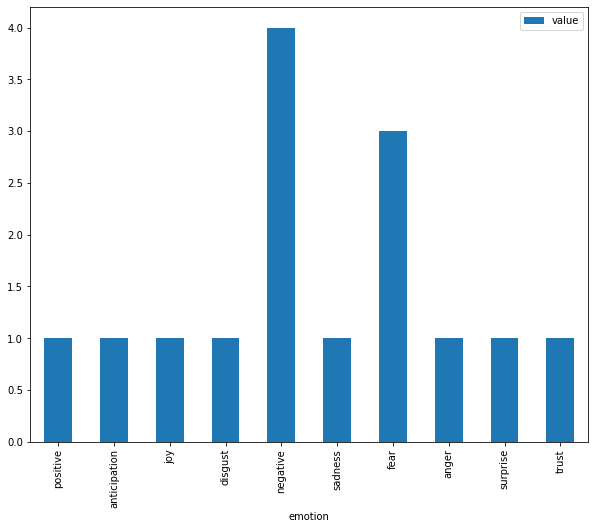

In [114]:
all_emotion_list = []
all_emotion_value = []

for emotion in all_emotion_dic:
    if emotion not in all_emotion_list:
        all_emotion_list.append(emotion)
        all_emotion_value.append(all_emotion_dic.get(emotion))
        
#print(emotion_list,ukraine_emotion_value,russia_emotion_value)
all_emotion_df = pd.DataFrame({'emotion':all_emotion_list,'value':all_emotion_value})
all_emotion_df.plot(x="emotion", y= "value", kind="bar",figsize=(10,8))

#### 3- Noun/Adjective

In [138]:
import spacy

def noun_adj(tweet):
    nlp = spacy.load('en_core_web_sm')
    text = str(tweet)
    doc = nlp(text)
    noun_adj_pairs = {}

    for chunk in doc.noun_chunks:
        adj = []
        noun = ""
        for tok in chunk:
            if tok.pos_ == "NOUN":
                noun = tok.text
            if tok.pos_ == "ADJ" or tok.pos_ == "CCONJ":
                adj.append(tok.text)
        if noun:
            noun_adj_pairs.update({noun:" ".join(adj)})

    return noun_adj_pairs


In [139]:
 len(tweet_df[(tweet_df['ukraine'] == True) & (tweet_df['russia'] == True)]['cleanText'])

4304

In [141]:
# WARNING : Take long time for execute (5 hours to execute ~ 4000 rows)
noun_adj_dic ={}
#for x in tweet_df[(tweet_df['ukraine'] == True) & (tweet_df['russia'] == True)]['cleanText']:
for x in tweet_df['cleanText']: 
    noun_adj_dic.update(noun_adj(x))

noun_adj_dic

{'toilet': 'flush fancy',
 'moron': '',
 'grantrandom': '',
 'sxmoctane': '',
 'stephenking': '',
 'jrscqnvtg': 'ucraina',
 'whisperer': '',
 'problem': '',
 'defense': '',
 'superpower': 'ukraine',
 'tktqzmmlkq': 'much big',
 'people': '',
 'life': 'good real',
 'avenger': '',
 'website': 'official ukrainian',
 'oerq': 'low',
 'slate': '',
 'bully': '',
 'attention': '',
 'kid': '',
 'deal': 'great',
 'event': '',
 'country': '',
 'seat': 'ukraine ussr permanent',
 'member': '',
 'blood': '',
 'adoremals': '',
 'battle': '',
 'business': '',
 'trader': '',
 'sanction': 'ajenglish',
 'barronsonline': '',
 'dn': '',
 'nmhnkzh': '',
 'nigerians': '',
 'issue': 'big',
 'yyvz': '',
 'question': '',
 'fault': '',
 'shit': '',
 'popsickles': '',
 'right': 'nuclear',
 'fact': '',
 'protect': 'ukraine',
 'tier': '',
 'risk': '',
 'stay': 'ukraine',
 'cd': '',
 'ukraine': 'russian',
 'mistyasummers': '',
 'promotion': '',
 'death': '',
 'dikri': '',
 'tomfromtartu': 'asegpi',
 'dictatorship': '

In [142]:
russia_adj = []
ukrania_adj = []
for x, y in noun_adj_dic.items():
    if 'russia' in x or 'russian' in x:
        russia_adj.append(y)
    elif 'russia' in y or 'russian' in y:
        russia_adj.append(x)
    elif 'ukraine' in x or 'ukrainian' in x:
        ukrania_adj.append(y)
    elif 'ukraine' in y or 'ukrainian' in y:
        ukrania_adj.append(x)

In [143]:
print('russia_adj: ', russia_adj)
print('ukrania_adj: ', ukrania_adj)

russia_adj:  ['ukraine', 'area', 'doctor', 'charity', 'food', 'regime', 'phkdtjrdta', 'civilian', 'zbz', 'ttzvhap', 'soldier', 'wgjszkwv', 'convoy', '', 'patrol', 'county', 'activity', 'eomdhtkndv', 'solder', 'kill', 'building', 'flat', 'bone', 'crime', 'ehlrfy', 'stopwarinukraine', 'puppet', '', 'jgqtuuj', 'news', 'decision', 'stall', 'fighte', 'asset', 'lcokosx', 'fvldnyhhja', 'aggresion', 'society', 'vlm', 'line', 'ukraine', 'mall', 'attack', 'ship', 'sevastopol', 'entity', 'rubble', 'kfhlquyeiu', 'qvekx', 'diplomat', 'mom', 'znvzjtbsvg', 'info', 'espionage', 'liberator', 'wiwbs', '', 'ukraine foreign mercenary', 'olfv', 'qsu', 'tvpjt', 'cjxa', 'squf', 'fvdfjsfpf', 'white manifest medium ukrainerussiawar', 'channel', 'dismay', 'indyref', 'tlalyd', 'movement', 'pcu', 'troop', 'fyft', 'rz', 'ccgaqvuirs', 'kiev', 'unity', 'lwsquvwbpb', 'stevastopol', 'vpdytycikv', 'gzraxwmkud', 'crypto', 'genz', 'artillery', 'pbgcluuuda', 'mil', 'hosqc', 'vvsmxhffob', 'venicebiennale', 'unitednations',

In [144]:
russia_words = set(russia_adj)
stopwords = ['ukraine', 'russiaukraine', 'ukrainian', 'russia']
stopwords = set(stopwords)
russia_adj_final = russia_words - stopwords
russia_adj_final = list(russia_adj_final)

ukrania_words = set(ukrania_adj)
ukrania_adj_final = ukrania_words - stopwords
ukrania_adj_final = list(ukrania_adj_final)


In [150]:
for x in ukrania_adj_final:
    if str(x).__contains__('ukraine'):
        ukrania_adj_final.remove(x)

In [162]:
# clean the adjective list

for x in ukrania_adj_final:
    if x not in words.words():
        ukrania_adj_final.remove(x)

for x in russia_adj_final:
    if x not in words.words():
        russia_adj_final.remove(x)

In [221]:
#ukrania_adj_final.remove('eozga')
russia_adj_final.remove('gfgff')

In [218]:
'cnzn' in words.words()

False

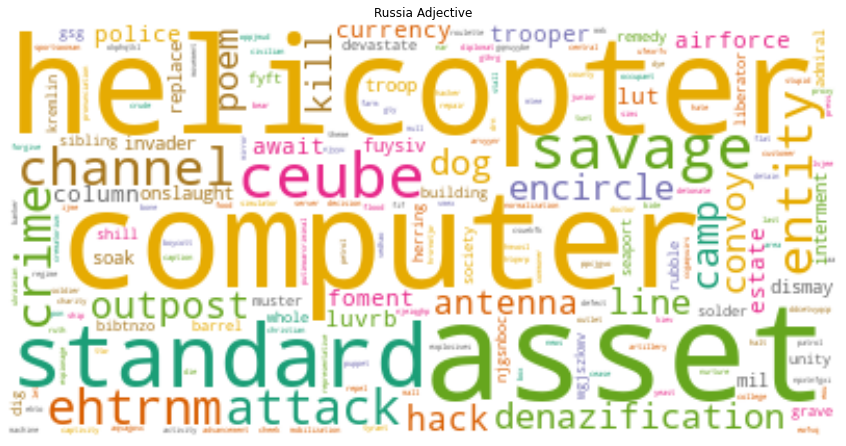

In [222]:
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

adj_word = " ".join(title for title in russia_adj_final)
plt.rcParams['figure.figsize'] = [16, 6]

cloud = wc.generate(adj_word)
plt.axis("off")
plt.title("Russia Adjective")
plt.tight_layout(pad = 0)
plt.imshow(cloud, interpolation='bilinear')
plt.show()

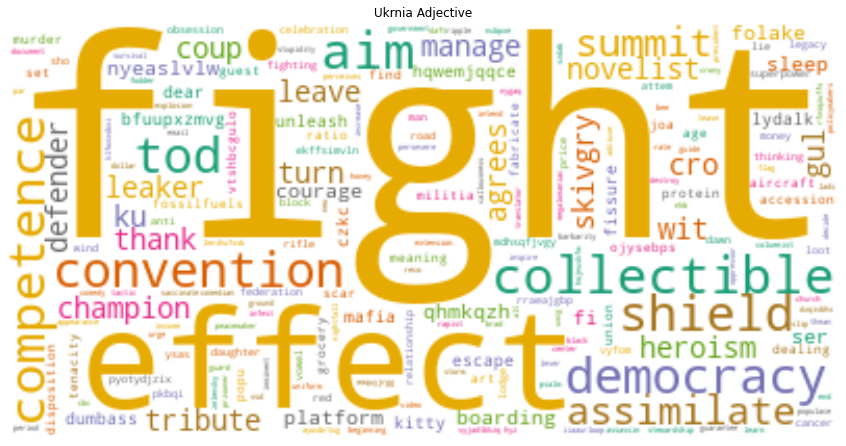

In [204]:
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

ukrania_word = " ".join(title for title in ukrania_adj_final)
plt.rcParams['figure.figsize'] = [16, 6]

cloud = wc.generate(ukrania_word)
plt.axis("off")
plt.title('Ukrnia Adjective')
plt.tight_layout(pad = 0)
plt.imshow(cloud, interpolation='bilinear')
plt.show()

In [ ]:
#https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

-------------------------------------

#### Save Cleaned Data

Save the cleaned data to cleaned_data.csv

In [ ]:
tweet_df = tweet_df[['tweetID','tweetText','tweetdate','date','countrycode']]
# Overwrite or add
ans = input('Do you want overwrite the file? (y/n): ')
if (ans == 'y'):
    tweet_df.to_csv('./data/cleaned_data.csv', index=False)
else:  
    # check if the file exist, it will add the data 
    try:
        with open('./data/cleaned_data.csv') as f:
            print('Add The data to the existing file')
            tweet_df.to_csv('./data/cleaned_data.csv',mode='a', header=False, index=False)
    except IOError:
       print('Create new file')
       tweet_df.to_csv('./data/cleaned_data.csv', index=False)

In [ ]:
cleaned_tweet_df = pd.read_csv('./data/cleaned_data.csv')
cleaned_tweet_df.shape

In [ ]:
cleaned_tweet_df.head()